/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists wi

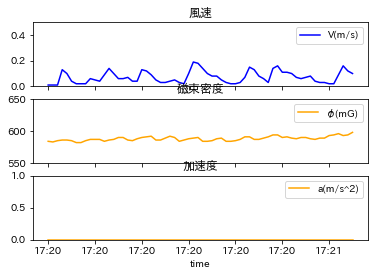

In [4]:
import numpy as np
from preprocess_data import preprocess_for_Siamese_Net
from train import ConvLayer2D,windEncoder,CombinedEncoder,DummyDataset,ContrastiveLoss
import torch; torch.utils.backcompat.broadcast_warning.enabled = True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import datetime as dt

preprocess = preprocess_for_Siamese_Net()

#walk_merged_df = preprocess.convert_csv_to_mergedcsv('data/csv/climomaster/walk/2023-0417-air.KAM.CSV','data/csv/ML-logger/walk/2023-0417-walk2-gauss.csv')
#air_merged_df = preprocess.convert_csv_to_mergedcsv('data/csv/climomaster/air/2023-1109-air.KAM.CSV','data/csv/ML-logger/air/2023-1109-air.csv')
#no_merged_df = preprocess.convert_csv_to_mergedcsv('data/csv/climomaster/no/2023-0318.KAM.CSV','data/csv/ML-logger/no/2023-0318-gauss.csv')
merged_df_1109 = preprocess.convert_csv_to_mergedcsv('data/csv/climomaster/1109/2023-1109-walk.KAM.CSV','data/csv/ML-logger/1109/2023-1109-walk.csv')


In [2]:
!pip install japanize_matplotlib

     |████████████████████████████████| 4.1 MB 9.3 MB/s eta 0:00:01
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=23a6b1f6d1a893251097063d4b5d4eaa664553e91c6da8ef05518e8e21d03a5f
  Stored in directory: /home/yk/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [ ]:
import pandas as pd
def slide_time_data(df:pd,slide_length:int,segment_data_length:int,
                        is_wind_vel_converted: bool = True,
                        is_temp_converted: bool = False,
                        is_humid_converted: bool = False,
                        is_gauss_converted: bool = True) ->list:
    """
    """

    #データを選ぶ
    if is_wind_vel_converted == False:
        df = df.drop('V(m/s)', axis=1)
    
    if is_temp_converted == False:
        df = df.drop('T(C)', axis=1)
    
    if is_humid_converted == False:
        df = df.drop('H(%RH)', axis=1)
    
    if is_gauss_converted == False:
        df = df.drop('φ(mG)', axis=1)   
    
    #出力配列
    segmented_datafarme_array = []

    #segment
    for i in range(0, len(df), slide_length):
        segment_dataframe = df[i:i+segment_data_length]
        if segment_dataframe.shape == (segment_data_length,len(df.columns)):
            segmented_datafarme_array.append(segment_dataframe)

    return  segmented_datafarme_array




walk_segment_data_list = slide_time_data(walk_merged_df,4,30)
no_segment_data_list = slide_time_data(no_merged_df[300:300+len(walk_merged_df)],4,30)

feat_list = list(walk_segment_data_list[0].columns.values.tolist())
walk_feat1 = []
walk_feat2 = []
no_feat1 = []
no_feat2 = []

for walk_df,no_df in zip(walk_segment_data_list,no_segment_data_list):
    walk_feat1.append(walk_df[feat_list[0]].values)
    no_feat1.append(no_df[feat_list[0]].values)
    walk_feat2.append(walk_df[feat_list[1]].values)
    no_feat2.append(no_df[feat_list[1]].values)

feat1_a = []
feat1_b = []
feat1_y = []

"feat1"
for wave_1 in walk_feat1:
    for wave_2 in walk_feat1:
        feat1_a.append(wave_1)
        feat1_b.append(wave_2)
        feat1_y.append(1)

for wave_1 in no_feat1:
    for wave_2 in no_feat1:
        feat1_a.append(wave_1)
        feat1_b.append(wave_2)
        feat1_y.append(0)

for wave_1 in walk_feat1:
    for wave_2 in no_feat1:
        feat1_a.append(wave_1)
        feat1_b.append(wave_2)
        feat1_y.append(-1)

for wave_1 in no_feat1:
    for wave_2 in walk_feat1:
        feat1_a.append(wave_1)
        feat1_b.append(wave_2)
        feat1_y.append(-1)

feat2_a = []
feat2_b = []
feat2_y = []

#feat2
for wave_1 in walk_feat2:
    for wave_2 in walk_feat2:
        feat2_a.append(wave_1)
        feat2_b.append(wave_2)
        feat2_y.append(1)

for wave_1 in no_feat2:
    for wave_2 in no_feat2:
        feat2_a.append(wave_1)
        feat2_b.append(wave_2)
        feat2_y.append(0)

for wave_1 in walk_feat2:
    for wave_2 in no_feat2:
        feat2_a.append(wave_1)
        feat2_b.append(wave_2)
        feat2_y.append(-1)

for wave_1 in no_feat2:
    for wave_2 in walk_feat2:
        feat2_a.append(wave_1)
        feat2_b.append(wave_2)
        feat2_y.append(-1)

label=[]

#ラベリング
for i in range(len(feat2_a)):
    if(feat1_y[i] == -1 or feat2_y[i] == -1):
        label.append(0)
    elif(feat1_y[i] == feat2_y[i]):
        label.append(1)
    else:
        label.append(0)

#npyファイルに変換s
datadir = "data/train-npy/"
np.save(datadir + 'wind_a_set', feat1_a)
np.save(datadir + 'wind_b_set', feat1_b)
np.save(datadir + 'gauss_a_set', feat2_a)
np.save(datadir + 'gauss_b_set', feat2_b)
np.save(datadir + 'labels', label)


In [ ]:
datadir = "data/train-npy/"
checkpoints_dir = "data/checkpoints/"
logs_dir = "data/logs/"

true_gauss = np.load(datadir + 'gauss_a_set.npy')
true_wind = np.load(datadir + 'wind_a_set.npy')
wrong_gauss = np.load(datadir + 'gauss_b_set.npy')
wrong_wind = np.load(datadir + 'wind_b_set.npy')
label = np.load(datadir + 'labels.npy')

traindataset = DummyDataset(true_gauss[0:75000],true_wind[0:75000],wrong_gauss[0:75000],
                       wrong_wind[0:75000],label[0:75000])

valdataset = DummyDataset(true_gauss[75000:99999],true_wind[75000:99999],wrong_gauss[75000:99999],
                       wrong_wind[75000:99999],label[75000:99999])

epochs = 50
batch_size = 128
train_dataloader = DataLoader(traindataset, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(valdataset, batch_size = batch_size, shuffle=True)

#test_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loss_fn = nn.CosineEmbeddingLoss().to(device)
loss_fn = ContrastiveLoss().to(device)
model = CombinedEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
model.train() 
torch.set_grad_enabled(True)
print("STARING TO TRAIN MODEL")
train_loss_list = []
val_acc_list = []
file1 = open(logs_dir + "training_accuracies.txt","w")
file2 = open(logs_dir + 'validation_accuracies.txt','w')
for epoch in range(1, epochs+1):
    model.train()
    steps_losses = []
    steps_accu = []
    model_checkpoints = checkpoints_dir + "model_" + str(epoch) + ".pt"
    for steps, (true_gauss_tensor, true_wind_tensor, wrong_gauss_tensor, wrong_wind_tensor, labels) in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
        optimizer.zero_grad() 
        true_gauss_tensor = torch.unsqueeze(true_gauss_tensor, dim = 1)
        true_wind_tensor = torch.unsqueeze(true_wind_tensor, dim = 1)
        wrong_gauss_tensor = torch.unsqueeze(wrong_gauss_tensor, dim = 1)
        wrong_wind_tensor = torch.unsqueeze(wrong_wind_tensor, dim = 1)
        true_gauss_tensor = torch.unsqueeze(true_gauss_tensor, dim = 3)
        true_wind_tensor = torch.unsqueeze(true_wind_tensor, dim = 3)
        wrong_gauss_tensor = torch.unsqueeze(wrong_gauss_tensor, dim = 3)
        wrong_wind_tensor = torch.unsqueeze(wrong_wind_tensor, dim = 3)

        genuine_output = model(true_gauss_tensor.to(device), true_wind_tensor.to(device))
        forged_output = model(wrong_gauss_tensor.to(device), wrong_wind_tensor.to(device))
        loss,y_pred = loss_fn(genuine_output, forged_output, labels.to(device))
        steps_losses.append(loss.cpu().detach().numpy())
        train_loss_list.append(loss)
        prediction = (y_pred.cpu().detach().numpy()>0.4).astype(np.int)
        accuracy = accuracy_score(labels,prediction)
        steps_accu.append(accuracy)
        loss.backward()
        optimizer.step()

    now_time = dt.datetime.now()
    print(f"EPOCH {epoch}| Train:  loss {np.mean(steps_losses)}| accuracy {np.mean(steps_accu)} {now_time}")
    file1.write("%s , %s, %s, %s, %s, %s\n" % (str(epoch), "train_loss", str(np.mean(steps_losses)), "train_accuracy", str(np.mean(steps_accu)), now_time))
    torch.save(model.state_dict(),model_checkpoints)
    scheduler.step()
    model.eval()
    with torch.no_grad():
        for steps, (true_gauss_tensor, true_wind_tensor, wrong_gauss_tensor, wrong_wind_tensor, labels) in tqdm(enumerate(val_dataloader),total=len(val_dataloader)):
            true_gauss_tensor = torch.unsqueeze(true_gauss_tensor, dim = 1)
            true_wind_tensor = torch.unsqueeze(true_wind_tensor, dim = 1)
            wrong_gauss_tensor = torch.unsqueeze(wrong_gauss_tensor, dim = 1)
            wrong_wind_tensor = torch.unsqueeze(wrong_wind_tensor, dim = 1)
            true_gauss_tensor = torch.unsqueeze(true_gauss_tensor, dim = 3)
            true_wind_tensor = torch.unsqueeze(true_wind_tensor, dim = 3)
            wrong_gauss_tensor = torch.unsqueeze(wrong_gauss_tensor, dim = 3)
            wrong_wind_tensor = torch.unsqueeze(wrong_wind_tensor, dim = 3)

            genuine_output = model(true_gauss_tensor.to(device), true_wind_tensor.to(device))
            forged_output = model(wrong_gauss_tensor.to(device), wrong_wind_tensor.to(device))
            loss,y_pred = loss_fn(genuine_output, forged_output, labels.to(device))
            prediction = (y_pred.cpu().detach().numpy()>0.4).astype(np.int)
            accuracy = accuracy_score(labels,prediction)
            val_acc_list.append(accuracy)
            steps_accu.append(accuracy)
            steps_losses.append(loss.cpu().numpy())
        print(f"EPOCH {epoch}| Validation:  loss {np.mean(steps_losses)}| accuracy {np.mean(steps_accu)} {now_time}")
        file2.write("%s , %s, %s, %s, %s, %s\n" % (str(epoch), "val_loss", str(np.mean(steps_losses)), "val_accuracy", str(np.mean(steps_accu)), str(now_time)))
file1.close()
file2.close()



Adjusting learning rate of group 0 to 1.0000e-03.
STARING TO TRAIN MODEL


  0%|          | 0/586 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x128 and 15360x50)